In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import tifffile
from tqdm.notebook import tqdm
import cv2
import os
import copy

In [2]:
train_path = "../input/mayo-clinic-strip-ai/train.csv"
test_path = "../input/mayo-clinic-strip-ai/test.csv"
sub_path = "../input/mayo-clinic-strip-ai/sample_submission.csv"

In [3]:
train_images_path = "../input/mayo-clinic-strip-ai/train"
test_images_path = "../input/mayo-clinic-strip-ai/test"

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
train_images = glob(train_images_path + "/*.tif")
test_images = glob(test_images_path + "/*.tif")

In [6]:
train_images[:5]

['../input/mayo-clinic-strip-ai/train/a4c7df_0.tif',
 '../input/mayo-clinic-strip-ai/train/f9fc6b_0.tif',
 '../input/mayo-clinic-strip-ai/train/0d718a_0.tif',
 '../input/mayo-clinic-strip-ai/train/86e319_1.tif',
 '../input/mayo-clinic-strip-ai/train/54838a_0.tif']

In [7]:
from openslide import OpenSlide
Image.MAX_IMAGE_PIXELS = None

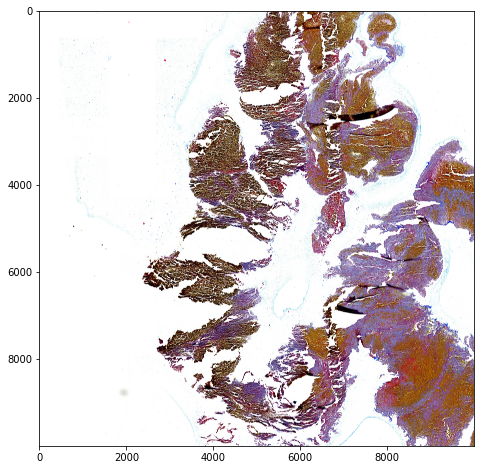

10000

In [18]:
slide = OpenSlide('../input/mayo-clinic-strip-ai/train/006388_0.tif') # opening a full slide

region = (0, 0) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (10000, 10000) # region size in pixels

region = slide.read_region(region, level, size)

plt.figure(figsize=(8, 8))
plt.imshow(region)
plt.show()
len(np.array(region))

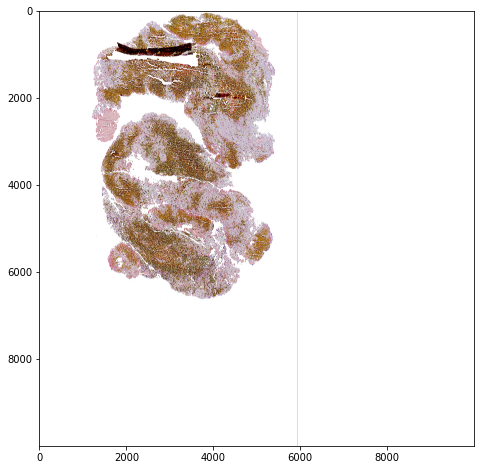

In [20]:
slide = OpenSlide('../input/mayo-clinic-strip-ai/train/008e5c_0.tif') # opening a full slide

region = (0, 0) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (10000, 10000) # region size in pixels

region = slide.read_region(region, level, size)

plt.figure(figsize=(8, 8))
plt.imshow(region)
plt.show()

In [21]:
len(train_images)

754

In [22]:
len(test_images)

4

In [23]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [24]:
train_df["label"][0]

'CE'

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, data_path, train=True, transform=None):
        self.data = pd.read_csv(data_path)
        self.train = train
        if train:
            self.labels = self.data["label"]
        self.img_dir = img_dir
        self.patient_ids = self.data["patient_id"]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        if self.train:
            label = self.labels[idx]  
            label = {"CE": 0, "LAA": 1}[label]
        patient_id = self.patient_ids[idx]
        image = cv2.resize(tifffile.imread(img_path + ".tif"), (224,224)).astype(np.float64)
        image /= 255
        image = np.transpose(image,(2,0,1))
        if self.transform:
            image = self.transform(image)
        if self.train:
            return image, label, patient_id
        return image, patient_id

In [8]:
train_data = CustomImageDataset(train_images_path, train_path)
data_train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
print(len(train_data))

754


In [17]:
len(train_data[54])

3

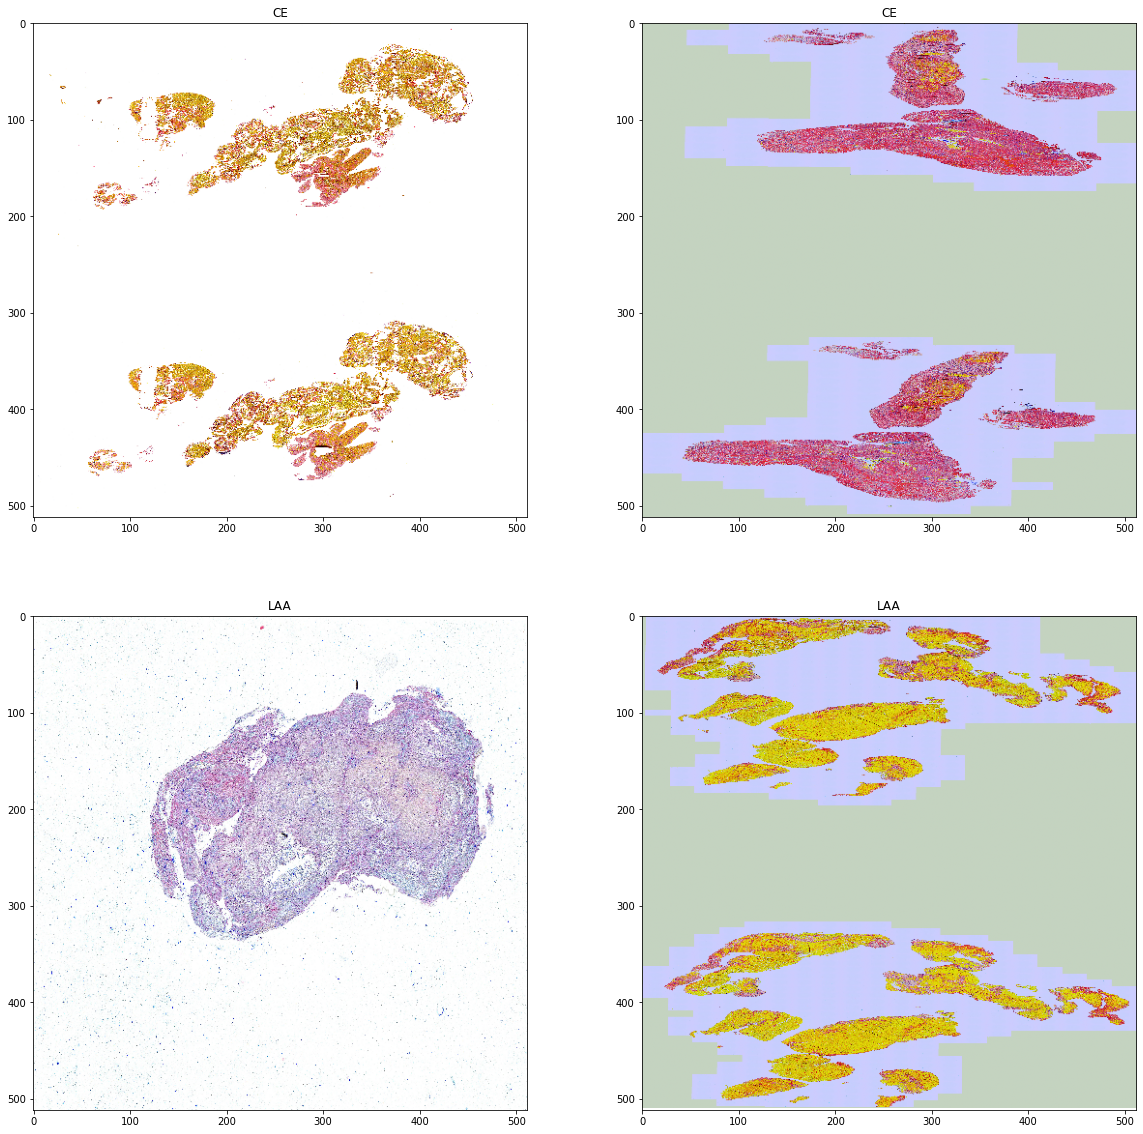

In [64]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(20, 20)

for i in range(2):
    for j in range(2):
        idx = np.random.randint(len(train_data))
        img, label, patient_i = train_data[idx]        
        axes[i, j].imshow(img)
        axes[i, j].set_title(label)

In [65]:
fig.savefig("STRIPAI2.png")

TODOS:
- Black and white images?
- Data Augmentation
- Models - ViT, Resnet, Basic CNN
- Batch size 1/2
- Need patient id with the data set too (__ __get_item__ __)

In [35]:
model = torchvision.models.resnet50()

In [36]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=1
    ),
    torch.nn.Sigmoid()
)

In [37]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

In [38]:
EPOCHS = 5
phase = "train"
USE_GPU = False

In [ ]:
for i in range(EPOCHS):
    for phase in ["train", "test"]:
        if phase == "train":
            model.train()
        
        samples = 0
        loss_sum = 0
        correct_sum = 0
        for j, batch in enumerate(data_train_loader):
            X = batch[0].type(torch.FloatTensor)
            labels = batch[1]
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y = model(X)
                loss = criterion(
                    y, 
                    labels.view(-1, 1).float()
                )

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
                loss_sum += loss.item() * X.shape[0] # We need to multiple by batch size as loss is the mean loss of the samples in the batch
                samples += X.shape[0]
                num_corrects = torch.sum((y >= 0.5).float() == labels.view(-1, 1).float())
                correct_sum += num_corrects
                
                # Print batch statistics every 50 batches
                if j % 50 == 49 and phase == "train":
                    print("{}:{} - loss: {}, acc: {}".format(
                        i + 1, 
                        j + 1, 
                        float(loss_sum) / float(samples), 
                        float(correct_sum) / float(samples)
                    ))
        # Print epoch statistics
        epoch_acc = float(correct_sum) / float(samples)
        epoch_loss = float(loss_sum) / float(samples)
        print("epoch: {} - {} loss: {}, {} acc: {}".format(i + 1, phase, epoch_loss, phase, epoch_acc))
        
        # Deep copy the model
        if phase == "test" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "resnet50.pth")

1:50 - loss: 0.9343578815273941, acc: 0.65
1:100 - loss: 0.7773120091762393, acc: 0.68
1:150 - loss: 0.7240978576429188, acc: 0.7066666666666667
1:200 - loss: 0.7173126061772928, acc: 0.7025
1:250 - loss: 0.7230257940553129, acc: 0.702
1:300 - loss: 0.7120080887991935, acc: 0.6983333333333334
1:350 - loss: 0.7053675985948316, acc: 0.6942857142857143
epoch: 1 - train loss: 0.7106341629681876, train acc: 0.6883289124668435


In [11]:
# Transform all images for faster training
image, label, patient_id = train_data[100]

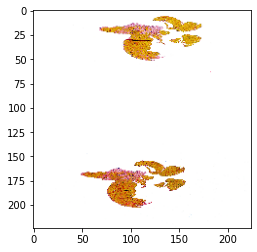

In [12]:
plt.imshow(np.transpose(image, (1, 2, 0)))

In [13]:
label

0

In [14]:
image2, label2, patient_id2 = train_data[10]

In [15]:
label2

1

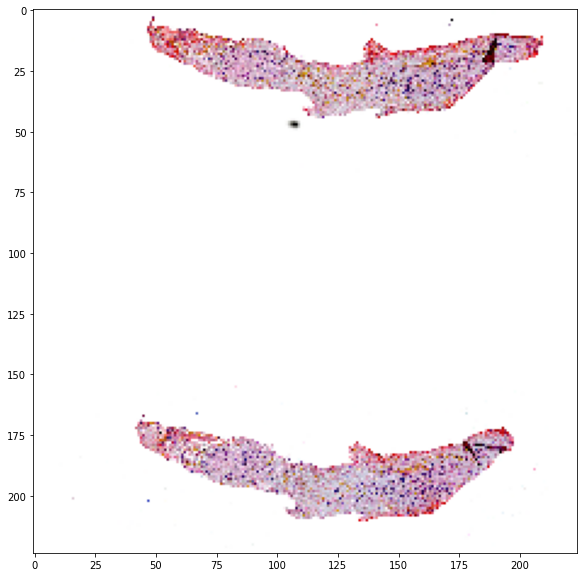

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(image2, (1,2,0)))

In [53]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

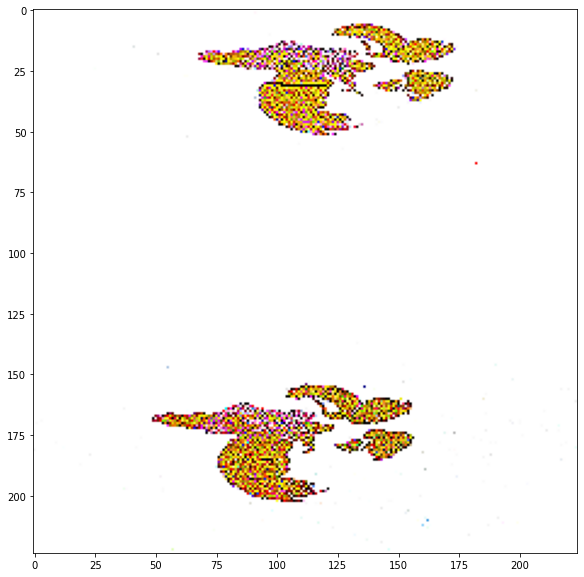

In [54]:
image_sharp = cv2.filter2D(src=np.transpose(image, (1,2,0)), ddepth=-1, kernel=kernel)
plt.figure(figsize=(10,10))
plt.imshow(image_sharp)

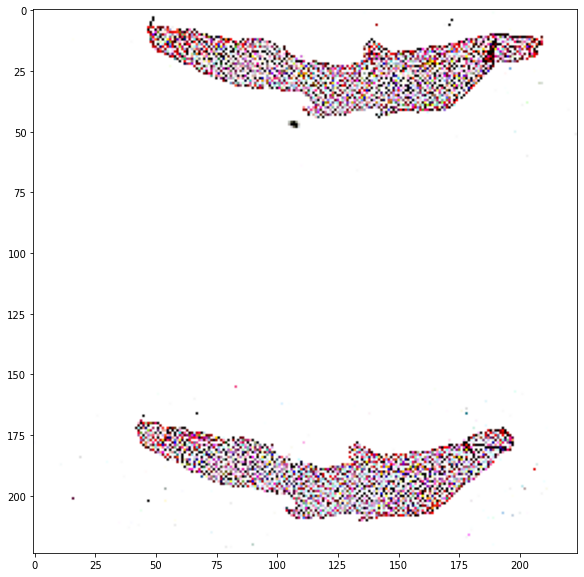

In [55]:
image_sharp = cv2.filter2D(src=np.transpose(image2, (1,2,0)), ddepth=-1, kernel=kernel)
plt.figure(figsize=(10,10))
plt.imshow(image_sharp)

In [10]:
image_path = "./train_images/"
for image in tqdm(train_images[157:]):
    resized_image = cv2.resize(tifffile.imread(image), (224,224))
    image_name = image.split('/')[-1].split('.')[0]
    cv2.imwrite(image_path + image_name + ".png", resized_image)

  0%|          | 0/597 [00:00<?, ?it/s]

In [58]:
cv2.imwrite?

Docstring:
imwrite(filename, img[, params]) -> retval
.   @brief Saves an image to a specified file.
.   
.   The function imwrite saves the image to the specified file. The image format is chosen based on the
.   filename extension (see cv::imread for the list of extensions). In general, only 8-bit
.   single-channel or 3-channel (with 'BGR' channel order) images
.   can be saved using this function, with these exceptions:
.   
.   - 16-bit unsigned (CV_16U) images can be saved in the case of PNG, JPEG 2000, and TIFF formats
.   - 32-bit float (CV_32F) images can be saved in PFM, TIFF, OpenEXR, and Radiance HDR formats;
.     3-channel (CV_32FC3) TIFF images will be saved using the LogLuv high dynamic range encoding
.     (4 bytes per pixel)
.   - PNG images with an alpha channel can be saved using this function. To do this, create
.   8-bit (or 16-bit) 4-channel image BGRA, where the alpha channel goes last. Fully transparent pixels
.   should have alpha set to 0, fully opaque pixels

1:50 - loss: 0.9343578815273941, acc: 0.65
1:100 - loss: 0.7773120091762393, acc: 0.68
1:150 - loss: 0.7240978576429188, acc: 0.7066666666666667
1:200 - loss: 0.7173126061772928, acc: 0.7025
1:250 - loss: 0.7230257940553129, acc: 0.702
1:300 - loss: 0.7120080887991935, acc: 0.6983333333333334
1:350 - loss: 0.7053675985948316, acc: 0.6942857142857143
epoch: 1 - train loss: 0.7106341629681876, train acc: 0.6883289124668435

In [22]:
images_new = glob("./train_images*")

In [23]:
images_new

['./train_images', './train_imagesa4c7df_0.png']

AttributeError: module 'cv2' has no attribute 'save'